In [58]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
summoner_name = "야식은치킨이지"
timeline = pd.read_json("data/{name}/timeline.json".format(name=summoner_name))

In [60]:
match_length = len(timeline)
metadata = pd.concat([pd.json_normalize(timeline["metadata"][match_idx]).iloc[:,1:] for match_idx in range(match_length)]).reset_index()

In [61]:
for i in range(100):
    time_played = len(timeline["info"][i]["frames"])
    if time_played >= 30:
        print(i, time_played)


1 34
3 39
7 36
8 40
9 37
13 42
16 34
17 40
27 32
28 37
30 32
38 33
45 31
47 37
49 30
50 38
52 34
60 42
65 33
74 30
75 35
76 50
77 37
88 34
89 39
97 41


In [96]:
match_index = 8
match_time_length = len(timeline["info"][match_index]["frames"])
events = [timeline["info"][match_index]["frames"][t]["events"] for t in range(match_time_length)]
participantFrames = [timeline["info"][match_index]["frames"][t]["participantFrames"] for t in range(match_time_length)]

마지막 골드 총량 [18865 20306 27639 21779 20162 22116 22835 21730 28425 17988]


<AxesSubplot:>

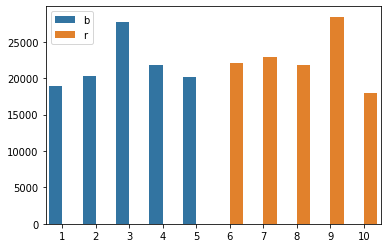

In [97]:
def get_total_gold(t):
    return(np.array([participantFrames[t][str(idx)]["totalGold"] for idx in range(1,11)]))

print("마지막 골드 총량", get_total_gold(match_time_length-1))
sns.barplot(x=np.arange(1,11), y=get_total_gold(match_time_length-1), hue=["b","b","b","b","b","r","r","r","r","r"])

In [98]:
total_gold = pd.DataFrame.from_records([get_total_gold(t) for t in range(match_time_length)])
total_gold_blue, total_gold_red = total_gold.iloc[:,:5], total_gold.iloc[:,5:]
total_gold_blue.head()

,0,1,2,3,4
0,950,950,950,950,950
1,950,950,950,950,990
2,1027,1076,1009,1027,1094
3,1296,1882,1564,1263,1399
4,1866,2770,2435,1745,1805


In [99]:
team_total_gold_blue = total_gold_blue.apply(lambda x: sum(x), axis=1)
team_total_gold_red = total_gold_red.apply(lambda x: sum(x), axis=1)

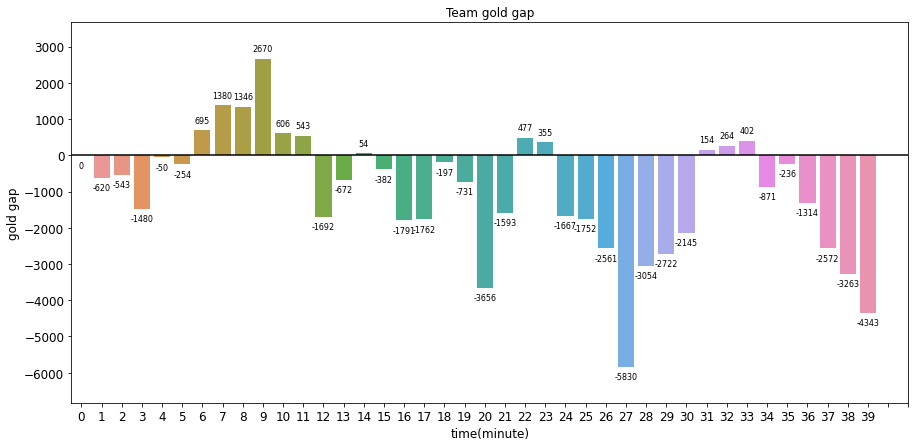

In [100]:
team_total_gold_gap = team_total_gold_blue-team_total_gold_red
# sns.lineplot(x=range(match_time_length), y=team_total_gold_gap)

plt.figure(figsize=(15,7))
plt.title("Team gold gap")
plt.xlabel('time(minute)', fontsize=12)
plt.ylabel('gold gap', fontsize=12)
g = sns.barplot(x=np.arange(match_time_length), y=team_total_gold_blue-team_total_gold_red, label="blue team gold - red team gold")
plt.xticks(np.arange(0, match_time_length+2, step=1), fontsize=12)
plt.yticks(np.arange(-20000, 20000, step=1000), fontsize=12)
plt.ylim(team_total_gold_gap.min()-1000, team_total_gold_gap.max()+1000)
plt.axhline(y=0, color="k")

for i in range(match_time_length):
    p = g.patches[i]
    g.annotate("%.0f"%p.get_height(), (p.get_x() + p.get_width()/2., p.get_height()), 
        ha='center', va='center', fontsize=8, color='k', xytext=(0, 10 if team_total_gold_gap[i] > 0 else -10), 
        textcoords='offset points')

In [101]:
diff = []
for i in range(1, match_time_length):
    diff.append(team_total_gold_gap[i] - team_total_gold_gap[i-1])
df_diff = pd.DataFrame(diff, columns=["diff"])
df_diff.index = range(1, match_time_length)

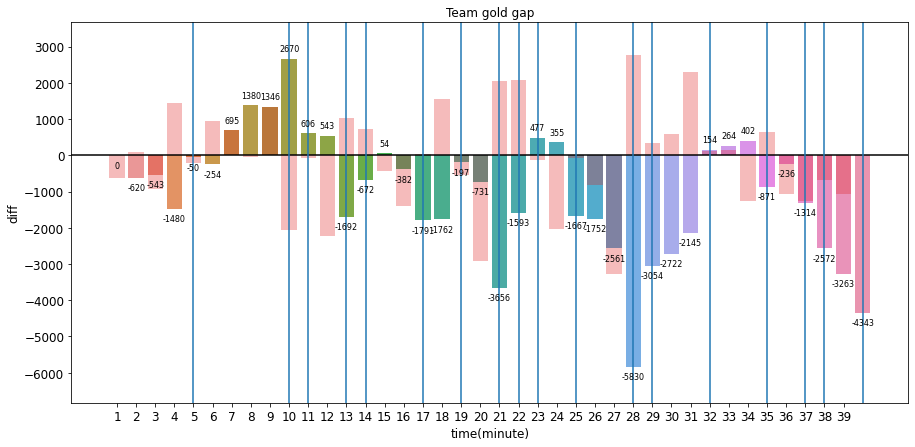

In [102]:
plt.figure(figsize=(15,7))
plt.title("Team gold gap")
plt.xlabel('time(minute)', fontsize=12)
plt.ylabel('gold gap', fontsize=12)
g = sns.barplot(x=np.arange(match_time_length), y=team_total_gold_blue-team_total_gold_red, label="blue team gold - red team gold")
plt.xticks(np.arange(0, match_time_length+2, step=1), fontsize=12)
plt.yticks(np.arange(-20000, 20000, step=1000), fontsize=12)
plt.ylim(team_total_gold_gap.min()-1000, team_total_gold_gap.max()+1000)
plt.axhline(y=0, color="k")

for i in range(match_time_length):
    p = g.patches[i]
    g.annotate("%.0f"%p.get_height(), (p.get_x() + p.get_width()/2., p.get_height()), 
        ha='center', va='center', fontsize=8, color='k', xytext=(0, 10 if team_total_gold_gap[i] > 0 else -10), 
        textcoords='offset points')

sns.barplot(data=df_diff, x=np.arange(1,match_time_length), y="diff", color="r", alpha=0.3)
for i in df_diff[abs(df_diff["diff"]) >= 1000].index:   # 1000골드 이상의 차이가 발생했을 때를 표시
    plt.axvline(x=i)

In [103]:
df_diff["kills"] = 0
df_diff["deaths"] = 0
df_diff["dragon_kills"] = 0
df_diff["baron_kills"] = 0
df_diff["dragon_killed"] = 0
df_diff["baron_killed"] = 0
df_diff["rift_herald_kills"] = 0
df_diff["rift_herald_killed"] = 0
df_diff["building_destroy"] = 0
df_diff["building_destroyed"] = 0
df_diff["turret_plate_destroy"] = 0
df_diff["turret_plate_destroyed"] = 0
df_diff["ace"] = 0

In [104]:
for idx in range(1, match_time_length):
    for e in events[idx]:
        # 관련 없는 이벤트 무시
        if e["type"] == "LEVEL_UP": continue
        if e["type"] == "SKILL_LEVEL_UP": continue
        if e["type"] == "WARD_PLACED": continue
        if e["type"] == "ITEM_DESTROYED": continue
        if e["type"] == "ITEM_PURCHASED": continue      # 돈을 사용하더라도 돈의 총량은 같음
        # 사소한 이벤트 무시
        if e["type"] == "ITEM_UNDO": continue
        if e["type"] == "WARD_KILL": continue
        # df_diff 갱신
        if e["type"] == "CHAMPION_KILL":
            if e["killerId"] <= 5:
                df_diff.loc[idx]["kills"] += 1
            else:
                df_diff.loc[idx]["deaths"] += 1
        if e["type"] == "CHAMPION_SPECIAL_KILL":
            if e["killType"] == "KILL_ACE":
                if e["killerId"] <= 5:
                    df_diff.loc[idx]["ace"] += 1
        if e["type"] == "ELITE_MONSTER_KILL":
            if e["monsterType"] == "DRAGON":
                if e["killerId"] <= 5:
                    df_diff.loc[idx]["dragon_kills"] += 1
                else:
                    df_diff.loc[idx]["dragon_killed"] += 1
            if e["monsterType"] == "RIFTHERALD":
                if e["killerId"] <= 5:
                    df_diff.loc[idx]["rift_herald_kills"] += 1
                else:
                    df_diff.loc[idx]["rift_herald_killed"] += 1
        if e["type"] == "TURRET_PLATE_DESTROYED":
            if e["teamId"] == 100:
                df_diff.loc[idx]["turret_plate_destroyed"] += 1
            if e["teamId"] == 200:
                df_diff.loc[idx]["turret_plate_destroy"] += 1
        if e['type'] == "BUILDING_KILL":
            if e["teamId"] == 100:
                df_diff.loc[idx]["building_destroyed"] += 1
            if e["teamId"] == 200:
                df_diff.loc[idx]["building_destroy"] += 1
        # display(pd.json_normalize(e))
        
        
        # print("type", e["type"])
        # if e["type"] == "CHAMPION_KILL":
        #     print("bounty :", e["bounty"])
        # print("")

In [105]:
idx_large_asc_diff = df_diff[df_diff["diff"] >= 500].index
idx_large_desc_diff = df_diff[df_diff["diff"] <= -500].index
display(df_diff.loc[idx_large_asc_diff])
display(df_diff.loc[idx_large_desc_diff])

,diff,kills,deaths,dragon_kills,baron_kills,dragon_killed,baron_killed,rift_herald_kills,rift_herald_killed,building_destroy,building_destroyed,turret_plate_destroy,turret_plate_destroyed,ace
4,1430,2,0,0,0,0,0,0,0,0,0,0,0,0
6,949,3,2,0,0,0,0,0,0,0,0,0,0,0
7,685,1,0,0,0,0,0,0,0,0,0,1,0,0
9,1324,3,0,1,0,0,0,0,0,0,0,0,2,0
13,1020,2,1,1,0,0,0,0,0,0,0,0,0,0
14,726,0,0,0,0,0,0,0,0,1,0,0,0,0
18,1565,1,0,0,0,0,0,0,0,1,0,0,0,0
21,2063,2,1,0,0,1,0,0,0,1,0,0,0,0
22,2070,2,1,0,0,0,0,0,0,1,0,0,0,0
28,2776,3,1,0,0,0,0,0,0,0,0,0,0,0


,diff,kills,deaths,dragon_kills,baron_kills,dragon_killed,baron_killed,rift_herald_kills,rift_herald_killed,building_destroy,building_destroyed,turret_plate_destroy,turret_plate_destroyed,ace
1,-620,0,1,0,0,0,0,0,0,0,0,0,0,0
3,-937,1,2,0,0,0,0,0,0,0,0,0,0,0
10,-2064,1,3,0,0,0,0,0,0,0,0,0,0,0
12,-2235,0,3,0,0,0,0,0,0,0,0,0,0,0
16,-1409,0,2,0,0,0,0,0,0,0,0,0,0,0
19,-534,0,2,0,0,0,0,0,0,0,0,0,0,0
20,-2925,1,4,0,0,0,0,0,0,0,2,0,0,0
24,-2022,2,5,0,0,0,0,0,0,0,0,0,0,0
26,-809,1,3,0,0,0,0,0,0,1,0,0,0,0
27,-3269,0,2,0,0,0,0,0,0,0,1,0,0,0


Text(0, 0.5, 'value')

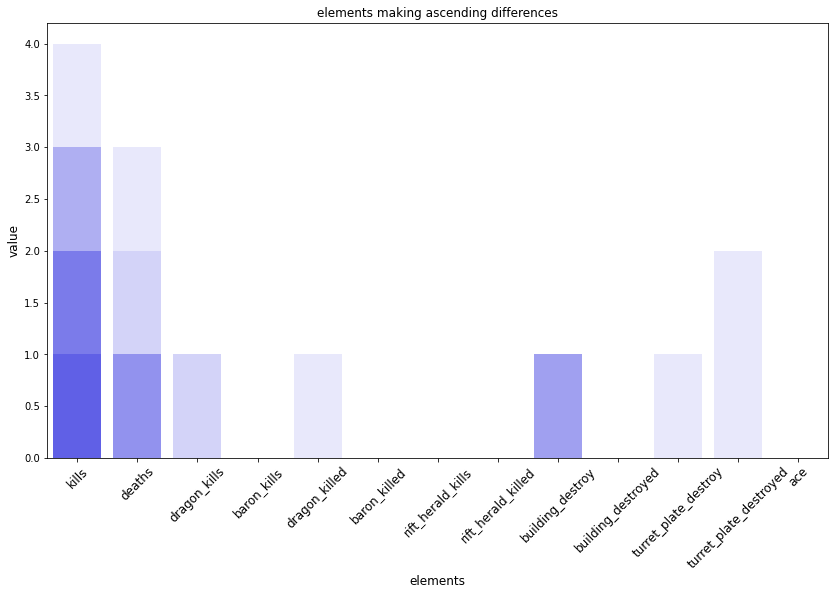

In [108]:
# plt.hist()
plt.figure(figsize=(14,8))
for idx in idx_large_asc_diff:
    sns.barplot(y=df_diff.iloc[idx-1,1:], x=df_diff.columns[1:], alpha=.1, color="blue")
plt.title("elements making ascending differences")
plt.xticks(rotation=45, fontsize=12)
plt.xlabel('elements', fontsize=12)
plt.ylabel('value', fontsize=12)

Text(0, 0.5, 'value')

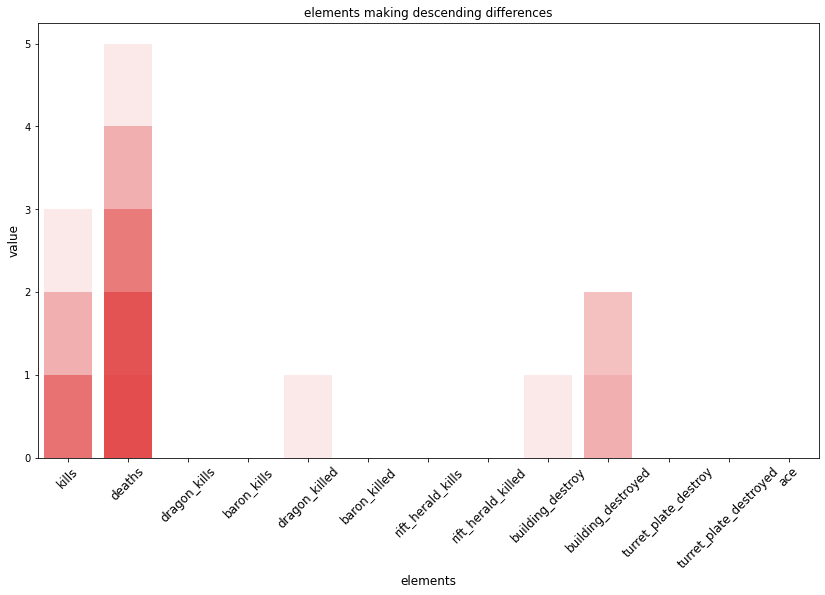

In [107]:
plt.figure(figsize=(14,8))
for idx in idx_large_desc_diff:
    sns.barplot(y=df_diff.iloc[idx-1,1:], x=df_diff.columns[1:], alpha=.1, color='red')
plt.title("elements making descending differences")
plt.xticks(rotation=45, fontsize=12)
plt.xlabel('elements', fontsize=12)
plt.ylabel('value', fontsize=12)
